In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("AQI.ipynb")

# Final Project: Air Quality Dataset
## Analyzing and Predicting AQI Data through Modeling
## Due Date: Thursday, December 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

## This Assignment

In this final project, we will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. The main goal at the end for you will be to understand how AQI varies both geographically and over time, and use your analysis (as well as other data that you can find) to be predict AQI at a certain point in time for various locations in California.

Through this final project, you will demonstrate your experience with:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

This is **part 1** of the project, which includes the data cleaning, guided EDA and open-ended EDA components of the project. This will help you for part 2, where you will be completing the modeling component. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [3]:
epa_weburl = "https://web.archive.org/web/20211118232504/https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("data/epa_filenames.csv")
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_county_2020
1,daily_county_aqi,daily_aqi_by_county_2020
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


Below is code that we used to extract the code from the AQI website, which we encourage you to understand! This will pull directly from the website urls and put it into your `data/` folder. 

In [4]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    # if not os.path.isdir(path_name): 
    data_url = '{}{}.zip'.format(epa_weburl, filename)
    req = requests.get(data_url)
    z = zipfile.ZipFile(io.BytesIO(req.content))
    z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

Use the below cell to explore each of the datasets, which can be accessed using the keys in the `name` column of `epa_filenames` above. Currently, the cell is viewing the `annual_county_aqi` dataset, but feel free to change it to whichever dataset you want to explore. 

In [5]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- BEGIN QUESTION -->

<br/>

### Question 0: Understanding the Data

Notice that for the table `annual_county_aqi`, the 90th percentile AQI is reported as a column. Why would the 90th percentile AQI be useful as opposed to the maximum? What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

<!--
BEGIN QUESTION
name: q0
manual: True
points: 2
-->

_It means that there are many outlier values when it comes to AQI, which may heavily skew our modeling._

<!-- END QUESTION -->

<br/>

### Question 1a: Creating Month and Day Columns

In the `daily_county_aqi` table in `epa_data`, add two new columns called `Day` and `Month` that denote the day and month, respectively, of the AQI reading. The day and month should both be reported as an **integer** as opposed to a string (`Jan`, `Feb`, etc.)

hint: `pd.to_datetime` may be useful.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [6]:
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.to_datetime(daily_county['Date']).dt.month
daily_county['Day'] = pd.to_datetime(daily_county['Date']).dt.month


daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,1
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,1
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,1
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,1


In [7]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

### Question 1b: California Data

Currently, `epa_data` contains data for **all** counties in the United States. For the guided part of this project, we are specifically going to be focusing on AQI data for counties in California only. Your task is to assign `epa_data_CA` a dictionary mapping table names to dataframes. This map should have the same contents as `epa_data` but only tables that contain **daily data** in the state of `California`.

<!--
BEGIN QUESTION
name: q1b
points: 3
-->

In [8]:
b = epa_data.get('daily_county_aqi')
b[b['State Name'] == 'California']

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14003,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14004,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,1
14005,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,1
14006,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,1
14007,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
33223,California,Yolo,6,113,2020-12-27,20,Good,Ozone,06-113-0004,2,12,12
33224,California,Yolo,6,113,2020-12-28,33,Good,Ozone,06-113-0004,2,12,12
33225,California,Yolo,6,113,2020-12-29,28,Good,Ozone,06-113-0004,3,12,12
33226,California,Yolo,6,113,2020-12-30,39,Good,PM2.5,06-113-0004,2,12,12


In [9]:
a = epa_data.get('aqs_sites')
a[a['State Name'] == 'California']['Site Number'].value_counts()

1       52
2       52
1001    46
3       44
4       41
        ..
1501     1
1406     1
1405     1
1404     1
3000     1
Name: Site Number, Length: 220, dtype: int64

In [10]:
epa_data_CA = epa_data.copy()
epa_data_CA.pop('annual_county_aqi')
epa_data_CA.pop('aqs_sites')
for key,value in epa_data_CA.items():
    newdata = epa_data_CA.get(key)
    newdata = newdata[newdata['State Name'] == 'California']
    epa_data_CA[key] = newdata
    
epa_data_CA.get('daily_county_aqi').head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14003,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14004,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,1
14005,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,1
14006,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,1
14007,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,1


In [11]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

### Question 1c: Merging Site Information

Now take a look at this [link](https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports) and look under "Site ID". For later analysis, we want to first get the latitude and longitudes of each of the measurements in the `daily_county_aqi` table by merging two or more tables in `epa_data_CA` (one of the tables is `daily_county_aqi`).

Our final merged table should be assigned to `epa_data_CA_merged` and the result should contain the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Latitude`, and `Longitude`

<!--
BEGIN QUESTION
name: q1c
points: 4
-->

In [12]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']

data1= epa_data_CA.get('daily_county_aqi')

array = []
iterate_array = data1['Defining Site']
for i in iterate_array:
    array.append(int(i[7:]))
    
data1['Site Number'] = array

data2 = epa_data.get('aqs_sites')

data2 = data2[data2['State Name'] == 'California']

epa_data_CA_merged = data1.merge(data2, on = ['County Code', 'Site Number'])

epa_data_CA_merged = epa_data_CA_merged.rename(columns = {'State Name_x': 'State Name'})
epa_data_CA_merged = epa_data_CA_merged[cols]
epa_data_CA_merged.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935
1,California,Alameda,1,1,40,Good,06-001-0009,37.743065,-122.169935
2,California,Alameda,7,7,48,Good,06-001-0009,37.743065,-122.169935
3,California,Alameda,7,7,115,Unhealthy for Sensitive Groups,06-001-0009,37.743065,-122.169935
4,California,Alameda,7,7,78,Moderate,06-001-0009,37.743065,-122.169935


In [13]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

### Question 2a - Cleaning Traffic Data 

Throughout this project, you will be using other datasets to assist with analysis and predictions. Traditionally, to join dataframes we need to join on a specific column with shared values. However, when it comes to locations, exact latitudes and longitudes are hard to come by since it is a continuous space. First, lets look at such a dataset that we may want to merge on with `epa_data_CA_merged`. 

In the below cell, we have loaded in the `traffic_data` dataset, which contains traffic data for various locations in California. Your task is to clean this table so that it includes only the following columns (you may have to rename some): `District`, `Route`, `County`, `Descriptn`, `AADT`, `Latitude`, `Longitude`, where `AADT` is found by taking the sum of the back and ahead `AADT`s (you may run into some issues with cleaning the data in order to add these columns - `.str` functions may help with this). The metric AADT, annual average daily traffic, is calculated as the sum of the traffic north of the route (ahead AADT) and south of the route (back AADT). You also need to make sure to clean and remove any illegal values from the dataframe (hint: check `Latitude` and `Longitude`).

*Hint:* `str` functions you will likely use: `.strip()`, `.replace()`.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [14]:
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")
traffic_data

,OBJECTID_1,OBJECTID,District,Route,Rte_SFX,County,PM_PFX,Postmile,PM_SFX,Descriptn,Back_pk_h,Back_pk_m,Back_AADT,Ahead_pk_h,Ahead_pk_m,Ahead_AADT,Lon_S_or_W,Lat_S_or_W,Lon_N_or_E,Lat_N_or_E
0,1,1,1,1,,MEN,,0.000,,SONOMA/MENDOCINO COUNTY LINE,,,,440,4650,4000,-123.5185026,38.75984264,-123.5185026,38.75984264
1,2,2,1,1,,MEN,,1.020,,NORTH LIMITS GUALALA,440,4650,4000,370,3700,3100,-123.53189,38.77004592,-123.53189,38.77004592
2,3,3,1,1,,MEN,,5.090,,FISH ROCK ROAD,320,3600,3100,210,2600,3100,-123.585411,38.80354931,-123.585411,38.80354931
3,4,4,1,1,,MEN,,14.692,,"POINT ARENA, SOUTH CITY LIMITS",240,2600,2200,240,2850,2400,-123.6915134,38.90397338,-123.6915134,38.90397338
4,5,5,1,1,,MEN,,15.180,,"POINT ARENA, RIVERSIDE DRIVE",250,2800,2400,250,2800,2600,-123.6924099,38.91091252,-123.6924099,38.91091252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7115,7116,7116,12,605,,ORA,,3.092,,"SEAL BEACH, JCT RTE 22",,,,3250,47000,46100,-118.0914735,33.7786335,-118.0908233,33.77861286
7116,7117,7117,12,605,,ORA,R,0.000,,JCT. RTE. 405,3250,47000,44700,11700,172000,167500,-118.0917676,33.78441396,-118.09138,33.78396418
7117,7118,7118,12,605,,ORA,R,1.405,,"LOS ALAMITOS, KATELLA AVENUE",11600,169000,159800,14100,173000,167000,-118.0820302,33.80279867,-118.0817329,33.80281106
7118,7119,7119,12,605,,ORA,R,1.643,,ORANGE/LOS ANGELES COUNTY LINE,14800,177000,170000,,,,-118.081547,33.80613969,-118.081287,33.8063525


In [15]:
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")

cols = ["District", "Route", "County", "Descriptn", "AADT", "Latitude", "Longitude"]
renaming = {"Lat_S_or_W": "Latitude", "Lon_S_or_W":  "Longitude"}
traffic_data = traffic_data.rename(columns = renaming)

traffic_data["Latitude"] = traffic_data["Latitude"].str.strip()
traffic_data["Latitude"] = traffic_data["Latitude"].str.replace(r'[a-zA-Z]', '')

traffic_data = traffic_data[~traffic_data["Latitude"].str.contains(" - ")]

traffic_data = traffic_data.replace(" ", 0)
traffic_data["AADT"] = traffic_data["Back_AADT"].astype(int) + traffic_data["Ahead_AADT"].astype(int)

traffic_data_cleaned = traffic_data[cols]

traffic_data_cleaned.head()

,District,Route,County,Descriptn,AADT,Latitude,Longitude
0,1,1,MEN,SONOMA/MENDOCINO COUNTY LINE,4000,38.75984264,-123.5185026
1,1,1,MEN,NORTH LIMITS GUALALA,7100,38.77004592,-123.53189
2,1,1,MEN,FISH ROCK ROAD,6200,38.80354931,-123.585411
3,1,1,MEN,"POINT ARENA, SOUTH CITY LIMITS",4600,38.90397338,-123.6915134
4,1,1,MEN,"POINT ARENA, RIVERSIDE DRIVE",5000,38.91091252,-123.6924099


In [16]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b - Merging on Traffic Data 

Traditionally, we could employ some sort of join where we join `epa_data_CA_merged` rows with the row in `traffic_data` that it is the "closest" to, as measured by euclidean distance. As you can imagine, this can be quite tedious so instead we will use a special type of join called a **spatial join**, which can be done using the package `geopandas`, which is imported as `gpd`. The documentation for `geopandas` is linked [here](https://geopandas.org/docs/reference/api/geopandas.sjoin_nearest.html). Please use this as a resource to do the following tasks: 

 - turn `traffic_data_cleaned` and `epa_data_CA_merged` into a geopandas dataframe using the latitude and longitude.
 - Use a spatial join (which function is this in the documentation?) to match the correct traffic row information to each entry in `epa_data_CA_merged`. 

Your final dataframe should be assigned to `gpd_epa_traffic` with the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Site Lat`, `Site Long`, `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [17]:
geom_traffic = gpd.points_from_xy(traffic_data_cleaned.Longitude, traffic_data_cleaned.Latitude)
geom_merged = gpd.points_from_xy(epa_data_CA_merged.Longitude, epa_data_CA_merged.Latitude)

gpd_traffic = gpd.GeoDataFrame(traffic_data_cleaned, geometry = geom_traffic)
gpd_CA_merged = gpd.GeoDataFrame(epa_data_CA_merged, geometry = geom_merged)

joined = gpd.sjoin_nearest(left_df = gpd_CA_merged, right_df = gpd_traffic, how = "inner") 

renaming = {"Latitude_left": "Site Lat", "Longitude_left": "Site Long", "Latitude_right": "Traffic Lat", 
            "Longitude_right": "Traffic Long"}

joined = joined.rename(columns = renaming)
joined["Traffic Long"] = joined["Traffic Long"].astype(str).astype(float)

cols = ["State Name", "county Name", "Month", "Day", "AQI", "Category", "Defining Site", "Site Lat", "Site Long", 
        "Traffic Lat", "Traffic Long", "Descriptn", "AADT"]

gpd_epa_traffic = joined[cols]

gpd_epa_traffic.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Site Lat,Site Long,Traffic Lat,Traffic Long,Descriptn,AADT
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935,37.74435189,-122.170586,"OAKLAND, 98TH AVENUE",48300
1,California,Alameda,1,1,40,Good,06-001-0009,37.743065,-122.169935,37.74435189,-122.170586,"OAKLAND, 98TH AVENUE",48300
2,California,Alameda,7,7,48,Good,06-001-0009,37.743065,-122.169935,37.74435189,-122.170586,"OAKLAND, 98TH AVENUE",48300
3,California,Alameda,7,7,115,Unhealthy for Sensitive Groups,06-001-0009,37.743065,-122.169935,37.74435189,-122.170586,"OAKLAND, 98TH AVENUE",48300
4,California,Alameda,7,7,78,Moderate,06-001-0009,37.743065,-122.169935,37.74435189,-122.170586,"OAKLAND, 98TH AVENUE",48300


In [18]:
grader.check("q2b")

q2b results: All test cases passed!

<br/><br/>

---
## Section 2: Guided EDA


### Question 3a: Initial AQI Analysis

Assign a `pd.Series` object to `worst_median_aqis` that contains the states with the top 10 worst median AQIs throughout the year 2020, as measured by the average median AQIs across all counties for a single state. Your result should have index `state`, the column value should be labelled `Average Median AQI`, and it should be arranged in descending order.

Now, assign the same thing to `worst_max_aqis`, except instead of aggregating the average median AQIs across all counties, aggregate the average **max AQIs** across all counties. Your result should have the same shape and labels as before, except the column value should be labelled `Average Max AQI`. 

Note: you may have to remove a few regions in your tables. Make sure every entry in your output is a **US State**.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [19]:
annual_data = epa_data.get('annual_county_aqi')

states = ["California", "Texas", "Florida", "Washington", "Hawaii", "Virginia", "Alaska", "Massachusetts", 
         "New Jersey", "Pennsylvania", "Montana", "North Carolina", "Arizona", "Georgia", "Ohio", "Colorado",
         "Illinois", "Michigan", "Oregon", "New York", "Minnesota", "Maryland", "Louisiana", "Connecticut", 
         "Tennessee", "Alabama", "Indiana", "Utah", "Maine", "Nevada", "New Mexico", "Missouri", "Wisconsin", 
         "Oklahoma", "South Carolina", "Kentucky", "Mississippi", "Wyoming", "Iowa", "Nebraska", "Idaho", "Kansas", 
         "Delaware", "Arkansas", "New Hampshire", "Vermont", "Rhode Island", "West Virginia", "South Dakota", 
         "North Dakota"]

annual_data = annual_data[annual_data["State"].isin(states)]

grouped_avg = annual_data.groupby("State").mean("Median AQI")
grouped_avg = grouped_avg.rename(columns = {"Median AQI": "Average Median AQI"})
grouped_avg = grouped_avg.sort_values("Average Median AQI", ascending = False)

grouped_max = annual_data.groupby("State").mean("Max AQI")
grouped_max = grouped_max.rename(columns = {"Max AQI": "Average Max AQI"})
grouped_max = grouped_max.sort_values("Average Max AQI", ascending = False)


worst_median_aqis = grouped_avg.head(10)["Average Median AQI"]
worst_max_aqis = grouped_max.head(10)["Average Max AQI"]


print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
print("Worst Max AQI : \n{}".format(worst_max_aqis))

np.round(list(worst_max_aqis), 2)

Worst Median AQI : 
State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Average Median AQI, dtype: float64

Worst Max AQI : 
State
Oregon          430.347826
Washington      334.419355
California      286.981132
Arizona         238.230769
Idaho           197.857143
Wyoming         196.666667
Nevada          196.666667
Montana         137.421053
Rhode Island    133.000000
Connecticut     124.750000
Name: Average Max AQI, dtype: float64


array([430.35, 334.42, 286.98, 238.23, 197.86, 196.67, 196.67, 137.42,
       133.  , 124.75])

In [20]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 3b: Worst AQI States

What are the states that are in both of the top 10 lists? Why do you think most of these states are on both of the lists?

<!--
BEGIN QUESTION
name: q3b
manual: True
points: 2
-->

_California, Arizona, and Connecticut are countries that make both top 10 lists. California had a devistating fire season that both maxxed poor air quality and also sustained it for a long period of time across the state. Moreover, large valleys and basins in California like the San Fernando Valley and Riverside County allow air to settle for long periods of time. This sustains poor air quality for longer pushing up the median AQI. As for Arizona, it also had an intense wildfire season in the year 2020 proving to be the largest season since 2011 (per wikipedia). Arizona is also a neighboring state of California which may have experienced a settling of a lot of the particulates from the California wildfires. Moreover, Arizona is a desert which does not experience much weather like rain which helps clear up the atmosphere, leading to a median push._

<!-- END QUESTION -->

<br/>

### Question 4a: Missing AQI Data

We want to see the accessibility of the AQI data across states. In the following cell, assign `days_with_AQI` to a series that contains the state as the index and the average number of days with AQI entries across all counties in that state as the value. Make sure to label the series as `Days with AQI` and sort in ascending order (smallest average number of days at the top). As before, make sure to remove the regions that are not **US States** from your series.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [21]:
days_with_AQI = annual_data.groupby('State').mean()
days_with_AQI = days_with_AQI.sort_values(by = 'Days with AQI', ascending = True)['Days with AQI']

days_with_AQI.head()

State
Alaska        235.222222
Arkansas      251.545455
New Mexico    264.062500
Virginia      265.303030
Colorado      278.892857
Name: Days with AQI, dtype: float64

In [22]:
grader.check("q4a")

q4a results: All test cases passed!

<br/>

### Question 4b: What are the missing dates?

In the following cell, we create the series `ca_aqi_days` that outputs a series with each county in California mapped to the number of days that they have AQI data on. Notice that there exists a few counties without the full year of data, which is what you will be taking a closer look at in the following two parts.

In [23]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(10)

54    274
96    331
63    351
98    353
49    359
76    360
51    364
57    364
72    365
79    366
Name: Days with AQI, dtype: int64

#### Question 4bi: Missing Days

Assign `county_to_missing_dates` to a dictionary that maps each county with less than the full year of data to the dates that have missing AQI data. Make sure that your keys are just the county name (no whitespace around it or `, California` appended to it) and the values are of the format `yyyy-mm-dd`.

<!--
BEGIN QUESTION
name: q4i
points: 2
-->

In [24]:
county_to_missing_dates = {}

missing_date_counties = ['Del Norte', 'Trinity', 'Lake', 'Tuolumne', 'Amador', 'Plumas', 'Calaveras', 'Glenn', 'Napa']
d1 = epa_data_CA.get('daily_county_aqi')
for county in missing_date_counties:
    curr_d1 = d1[d1['county Name'] == county]
    date_series = curr_d1['Date'].value_counts()
    idx = pd.date_range('01-01-2020', '12-31-2020')
    s = pd.Series(date_series)
    s.index = pd.DatetimeIndex(s.index)
    s = s.reindex(idx, fill_value=0)
    for index, value in s.items():
        if value == 0 and county not in county_to_missing_dates:
            county_to_missing_dates[county] = [str(index)[:10]]
        elif value == 0 and county in county_to_missing_dates:
            county_to_missing_dates[county].append(str(index)[:10])
            

In [25]:
grader.check("q4i")

q4i results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4bii: Missing Days

Are there any key missing dates in common between the counties that have missing AQI data? What two counties have the most missing days and why do you think they do?

<!--
BEGIN QUESTION
name: q4bii
manual: True
points: 2
-->

_There do not appear to be any missing dates in common between the counties that have missing AQI data; when inspecting the dictionary we see very few dates that are in more than one county.  The two counties that contain the most missing dates are Del Norte County and Trinity County.  These two counties are very close in proximity to one another (Northwest corner of California) and also have extremely low populations.  Together these two counties have a combined population of approximately 40,000 residents; thus, we infer that there may be a lack of AQI monitoring in this specific region due to the low number of people inhabiting this area._

<!-- END QUESTION -->



<br/>

### Question 5a: AQI over Time 

Assign `aqi_per_month` to a series of the average aqi per month across all US states and `aqi_per_month_CA` to a series of the average AQI per month across California.

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [26]:
x = epa_data.get('daily_county_aqi')
x = pd.DataFrame(x.groupby('Month').agg(np.mean))
aqi_per_month = x['AQI']

x_CA = epa_data_CA.get('daily_county_aqi')
x_CA = pd.DataFrame(x_CA.groupby('Month').agg(np.mean))
aqi_per_month_CA = x_CA['AQI']


print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


In [27]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 5b: AQI over Time Analysis 

Is there anything interesting that you notice in `aqi_per_month_CA`? If so, why do you think that is?

<!--
BEGIN QUESTION
name: q5b
manual: True
points: 1
-->

_Yes, we notice that there is an exceedingly high AQI level in September (107).  Also, we observe higher than usual AQI levels in the neighboring months of August (79) and October (75); whereas most other months hover around an AQI level of 40-50.  A possible explanation for this is that California experiences very severe wildfires during this time of the year; which is a direct cause of hieghtened AQI._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 5c: Modeling AQI over Time

Based on the AQI pattern in the year 2020, if we were to model AQI over the last 10 years, with the average AQI per year being the same, what sort of parametric function $f(x)$ would you use? Let us say that we see a linear increase in the average AQI per year over the last 10 years instead, then what parametric function $g(x)$ would you use?

<!--
BEGIN QUESTION
name: q5c
manual: True
points: 3
-->

_The parameteric function that represents a constant model: f(x) = a * cos($\omega$t + b) + $\theta$. 
The parametric function that represents a linear model: g(x) =a * cos($\omega$t + b) + c * t + $\theta$ ._

<!-- END QUESTION -->



<br/>

### Question 6a: Create Heatmap Buckets

Now we want to create a function called `bucket_data`, which takes in the following parameters: `table`, `resolution`. It outputs a pivot table with the latitude bucket (smallest latitude for that grid point) on the index and the longitude bucket (smallest longitude for that grid point) on the columns. The values in the pivot table should be the average AQI of the monitor sites inside that respective rectangle grid of latitudes and longitudes. The following should be the output of `bucket_data(epa_data_CA_merged, np.mean, 5)`:

<img src="images/q6a.png" width="600px" align="center"/>

The `resolution` parameter describes the number of buckets that the latitudes and longitudes are divided into on the heatmap. As an example, let us say that the range of longitudes for site monitors are between \[100, 110\]; make sure that the start of the range is exactly the **minimum** of all longitude values of your site monitors and the end of the range is the exactly the **maximum** of all longitude values of your site monitors. Let us say that we have a resolution of 10. Then we have the buckets 
$$([100, 101], [101, 102], ..., [109, 110])$$

The column and row labels of this dataframe should be labelled as the **start** of the bucket. In the case of the example above, the names of the buckets should be $ 100, 101, \dots 109 $. Note that we are just looking at the longitude dimension in this example, and you have to do do the same for the latitude dimension along the rows in order to build the pivot table.

Finally, make sure the row and column labels of your pivot table are **exactly** the same as the example given above. 
<!--
BEGIN QUESTION
name: q6a
points: 6
-->

In [28]:
def bucket_data(table, aggfunc, resolution):
    long_bucket = np.sort(np.linspace(table['Longitude'].min(), table['Longitude'].max(), num=resolution, endpoint = False))
    lat_bucket = np.sort(np.linspace(table['Latitude'].min(), table['Latitude'].max(), num=resolution, endpoint = False))

    long_bucket_map = dict(list(zip(long_bucket, np.around(long_bucket, decimals=2))))
    lat_bucket_map = dict(list(zip(lat_bucket, np.around(lat_bucket, decimals=2))))

    get_long_bucket_num = lambda loc: long_bucket_map.get(long_bucket[long_bucket <= loc].max())
    get_lat_bucket_num = lambda loc: lat_bucket_map.get(lat_bucket[lat_bucket <= loc].max())

    table['long_bucket'] = table['Longitude'].apply(get_long_bucket_num)
    table['lat_bucket'] = table['Latitude'].apply(get_lat_bucket_num)

    pivot_cols = ['lat_bucket', 'long_bucket', 'AQI']
    return pd.pivot_table(table[pivot_cols], index= 'lat_bucket', columns = 'long_bucket', aggfunc=aggfunc)


bucket_data(epa_data_CA_merged, np.mean, 5)

AQI                                            
long_bucket    -124.20    -122.28    -120.36    -118.44    -116.52
lat_bucket                                                        
32.58              NaN        NaN  65.317391  87.059645  67.955508
34.41              NaN  50.221983  67.597970  74.442308  58.294118
36.25        42.792276  51.489882  81.094254  74.704918        NaN
38.08        38.934803  53.699484  48.977778        NaN        NaN
39.92        38.790792  55.207065        NaN        NaN        NaN

In [29]:
grader.check("q6a")

q6a results: All test cases passed!

<br/>

### Question 6b: Visualize Heatmap

Assign `heatmap_data` to a heatmap bucket pivot table aggregated by median with resolution 30 for California AQI for the month of september. The code in the following cell will plot this heatmap for you. 

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

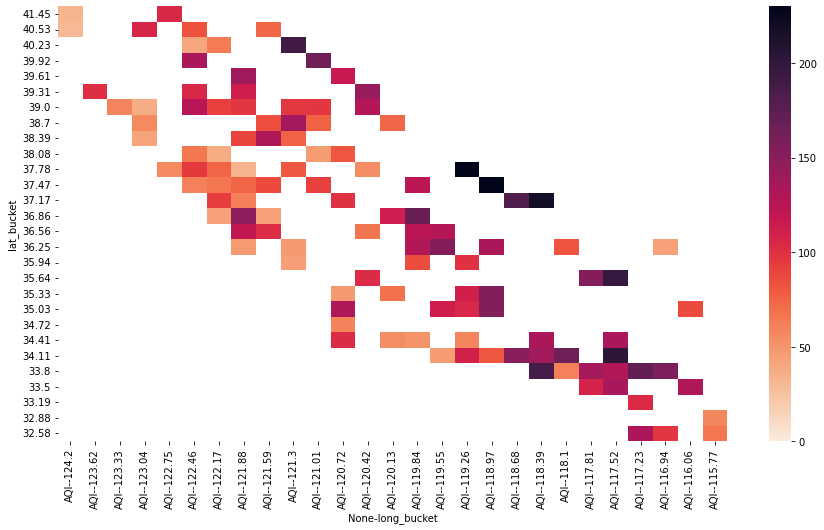

In [30]:
data = epa_data_CA_merged
data = data[data['Month'] == 9]

heatmap_data = bucket_data(data, np.median, 30)


#create visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [31]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 6c: Analyze Heatmap

Look up where the dark regions correspond to. Does this heatmap make sense?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

_This heat map makes a lot of sense because it corresponds to the shape of California. The coastlines, naturally, have the good air quality because ocean weather fronts clear the air and correspond to light colors. However, once we get to industrial regions like Los Angeles, despite being near the coast, has poor AQI and dark regions. Moreover, as we move inland to the Valleys, like the San Fernando Valley and Death Valley, as well as the heavily forested regions in the Sierra Nevada we start to see AQI levels rise._

<!-- END QUESTION -->



<br/><br/>

---
## Part 3: Open-Ended EDA

Not that we have explored the data both spatially and temporally, we want to be able to look at what other indicators there are for air quality in California. Through the previous few questions we have discussed that wilfire data as well as temperature may be good indicators, but we can explitly look at correlations via the temperature to verify our hypothesis. Like temperature, there are other columns of data such as particulate matter, chemical concentrations, wind data, etc. Your open-ended EDA will be useful for filling in missing points in the heatmap that you created in question 4b. 

Your goal in this question is to find relationships between AQI and other features in the current datasets, across time and space. Your exploration can include, but is not limited to: 
- Looking at correlations between AQI and various columns of interest in `epa_data_CA`.
    - This will require some merging, which you can look at question 1 for reference. 
- Performing clustering and/or other unsupervised learning methods such as PCA to discover clusters or useful (combinations of) features in the data.
- Merging and exploring other external datasets that you may think are useful.

<!-- BEGIN QUESTION -->

### Question 7a - Code and Analysis

Please complete all of your analysis in the **single cell** below based on the prompt above.

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 10
-->

In [32]:
from sklearn.pipeline import Pipeline,make_pipeline


#creating our merging and cleaning pipeline
def split_dates(df):
    df['Month'] = pd.to_datetime(df['Date Local']).dt.month  
    df['Day'] = pd.to_datetime(df['Date Local']).dt.day
    return df

def is_city(df):
    array = []

    for i in df["City Name"]:
        if i == "Not in a city":
            array.append(1)
        else:
            array.append(0)
    return df

def get_features(df):
    wanted = ["County Code", "Site Num", 
          "Month", "Day", "Arithmetic Mean"]
    
    return df[wanted]

wanted = ["County Code", "Site Number", "Month", "Day", "AQI"]
cleaned_AQI = epa_data_CA.get("daily_county_aqi")[wanted].rename(columns = {"Site Number": "Site Num"})

def data_creation():
    
    array = ["daily_wind", "daily_no2", "daily_ozone", "daily_temp", "daily_so2"]#, "daily_co"]
    
    names = ["Mean Wind Speed (Knots)", "Mean Nitrogen Dioxide (ppb)", "Mean Ozone (ppm)", "Mean Temp (F)"]
    
    storage = {}
    
    for i in range(len(array)):
        
        data = epa_data_CA.get(array[i])
        data = data.pipe(split_dates).pipe(is_city).pipe(get_features)
        #data_cleaned = data.groupby(["County Code", "Site Num", "Month"], as_index = False)
        #data_cleaned = data_cleaned.agg({"Arithmetic Mean": "mean"})
        #data_cleaned = data_cleaned.rename(columns = {"Arithmetic Mean": names[i]})
        
        storage[array[i]] = data
        
    return storage


def merge_data():
    
    start = data_creation()
    names = ["Mean Wind Speed (Knots)", "Mean Nitrogen Dioxide (ppb)", "Mean Ozone (ppm)", "Mean Temp (F)", 
             "Mean Sulphur Dioxide (ppb)"]#, "Mean Carbon Monoxide (ppb)"]

    values = []
    for key in start:
        values.append(key)
        
    index = 0
    
    merged = cleaned_AQI.merge(start[values[index]], on = ["County Code", "Site Num", "Month", "Day"])
    merged = merged.rename(columns = {"Arithmetic Mean": names[index]})
    index += 1
    # merged = merged.merge(start[values[index + 1]], on = ["County Code", "Site Num", "Month", "Day"])
    # merged = merged.merge(start[values[index + 2]], on = ["County Code", "Site Num", "Month", "Day"])
    # merged = merged.merge(start[values[index + 3]], on = ["County Code", "Site Num", "Month", "Day"])
    # merged = merged.merge(start[values[index + 4]], on = ["County Code", "Site Num", "Month", "Day"])
    # merged = merged.merge(start[values[index + 5]], on = ["County Code", "Site Num", "Month", "Day"])

    
    while index < len(start):
        
        merged = merged.merge(start[values[index]], on = ["County Code", "Site Num", "Month", "Day"])
        merged = merged.rename(columns = {"Arithmetic Mean": names[index]})
        index += 1
    
    #return merged.value_counts("County Code")
    data_cleaned = merged.groupby(["County Code", "Month"], as_index = False).mean()
    return data_cleaned
       
data = merge_data()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7b - Visualization

Please create **two** visualizations to summarize your analysis above. The only restrictions are that these visualizations **cannot** simply be scatterplots between two features in the dataset(s) and **cannot** be of the same type (dont make two bar graphs, for example). 

<!--
BEGIN QUESTION
name: q7b
manual: True
points: 4
-->

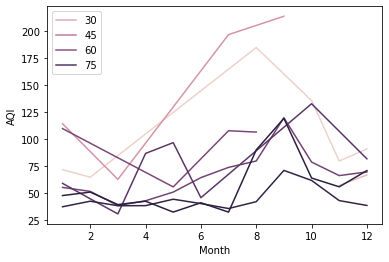

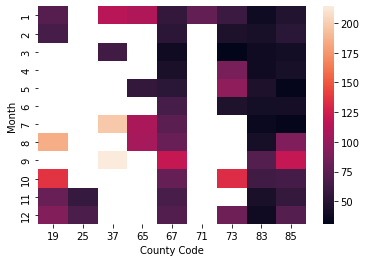

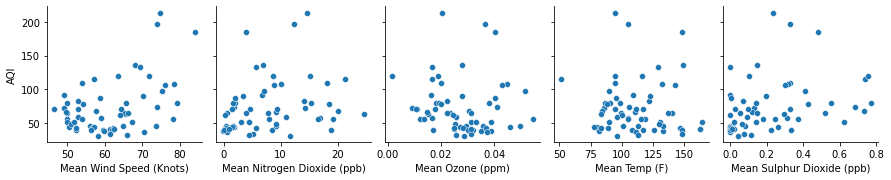

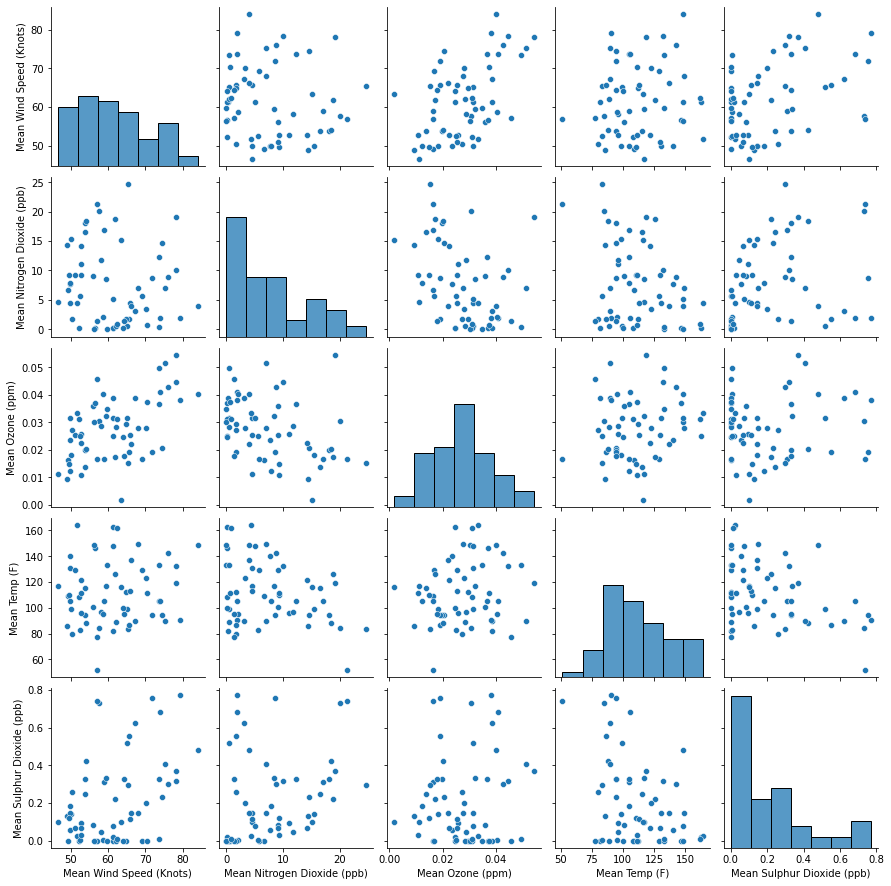

In [33]:
sns.lineplot(data=data, x='Month', y='AQI', hue='County Code')
plt.legend(loc='upper left')
plt.show()

piv = data.pivot("Month", "County Code", "AQI")
ax = sns.heatmap(piv)
plt.show()

pp = sns.pairplot(data=data,
                  x_vars=['Mean Wind Speed (Knots)', 'Mean Nitrogen Dioxide (ppb)', 'Mean Ozone (ppm)', 'Mean Temp (F)', 'Mean Sulphur Dioxide (ppb)'],
                  y_vars=['AQI'])
plt.show() 

pp2 = sns.pairplot(data=data,
                  x_vars=['Mean Wind Speed (Knots)', 'Mean Nitrogen Dioxide (ppb)', 'Mean Ozone (ppm)', 'Mean Temp (F)', 'Mean Sulphur Dioxide (ppb)'],
                  y_vars=['Mean Wind Speed (Knots)', 'Mean Nitrogen Dioxide (ppb)', 'Mean Ozone (ppm)', 'Mean Temp (F)', 'Mean Sulphur Dioxide (ppb)'])
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7c - Summary

In a paragraph, summarize the your findings and visualizations and explain how they will be useful for predicting AQI. Make sure that your answer is thoughtful and detailed in that it describes what you did and how you reached your conclusion. 

<!--
BEGIN QUESTION
name: q7c
manual: True
points: 4
-->

The first lineplot show how the average AQI changes per month in the year of 2020 for counties for which we have the following data: Mean Wind Speed (Knots), Mean Nitrogen Dioxide (ppb), Mean Ozone (ppm), Mean Temp (F), Mean Sulphur Dioxide (ppb). The lineplot shows a clear temporality to the data, specifically that average monthly AQI uniformly increases depending on the seasons; hotter summer months yield higher average AQIs, and vice versa.

The heat map shows roughly the same idea, however it also reveals that there are large chunks of monthly data missing for certain counties. We will have to map county codes to county names later on, as well as do some geographical mapping to see spatial trends.

The first of the set of two pairplots shows scatterplots of AQI and each of 'Mean Wind Speed (Knots)', 'Mean Nitrogen Dioxide (ppb)', 'Mean Ozone (ppm)', 'Mean Temp (F)', 'Mean Sulphur Dioxide (ppb)'. These scatterplots reveal that there is generally a very significant correlation between these variables and AQI, with the exception of temperature (which is a little more tenuous). This is very heartening to see and poses a great deal of avenues to investigate in the future.

The last pairplot set shows relationships between 'Mean Wind Speed (Knots)', 'Mean Nitrogen Dioxide (ppb)', 'Mean Ozone (ppm)', 'Mean Temp (F)', 'Mean Sulphur Dioxide (ppb)' and 'Mean Wind Speed (Knots)', 'Mean Nitrogen Dioxide (ppb)', 'Mean Ozone (ppm)', 'Mean Temp (F)', 'Mean Sulphur Dioxide (ppb)'. There are some interesting observations here as well, such as the fact that wind speed and ozone are very highly correlated. We plan to do PCA and see whether we can find redundant variables in situations like these.

<!-- END QUESTION -->



<br/><br/>

---
## Part 4: Guided Modeling

For this part, we will be looking at some open-ended modeling approaches to answering the question of predicting AQI given a location and a date. 

### Question 8 - Interpolation

For this part, we will be using a simple interpolation to find the missing grid values for AQI on the heatmap visualization that you produced in part 1. Simple linear interpolation just takes the locations' values and averages them to produce an estimate of the current location. Though this is not as predictive (we are not predicting based on features about the location itself), it will give you a sense of the task at hand for the remainder of the project. 

As a reminder, the heatmap produced after running the cell below is the one you produced for question 6b when creating a visualization for the AQI in California for the month of september. It produces white spaces where there exist `NaN` values in the pivot table. 

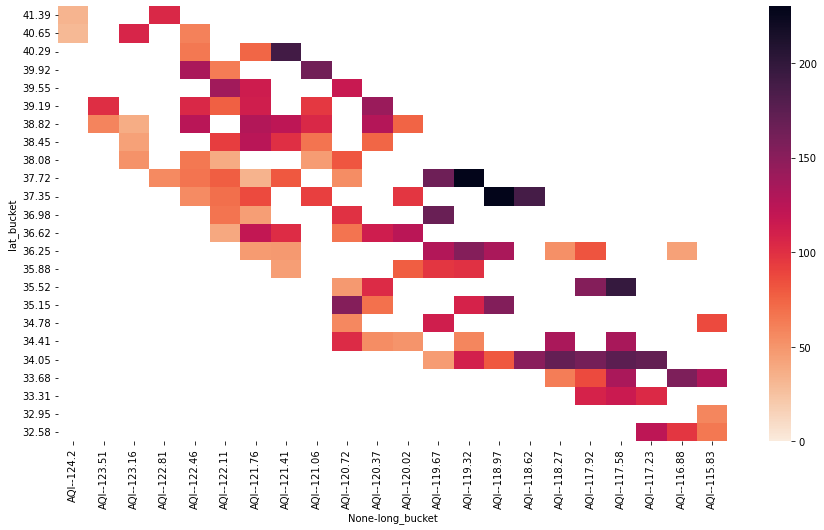

In [34]:
table_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(table_sep, np.median, 25)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

<br/>

### Question 8a - Simple Linear Interpolation
As previously mentioned, interpolation is a technique that is used to predict labels in a dataset by forming a model out of the data that is already labelled. In this case, we have a pivot table that we use to create a heatmap, but there contains many `NaN` values that we want to fill in. 

- Create the function `fill_bucket` that takes in the following parameters:
    - `pivot_table`: the pivot table that we are providing. 
    - `lat_bucket`: the bucket number that the latitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $, from lowest to highest value latitudes. 
    - `lon_bucket`: the bucket number that the longitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $. from lowest to highest value longitudes.
    
- In the pivot table, every value has cells above (A cells), cells below (B cells), cells to the left (L cells), and cells to the right (R cells). We will say that a direction (R for example) is valid if and only if there exists a cell **anywhere** to its right that is not `NaN`. The closest such cell will be called the "closest R cell". The same goes for the rest of the directions. For the cases below, assuming that our current cell is called cell K. 
    - If cell K is not `NaN`, then simply return the AQI at that given cell.
    - **Only** if there are **at least** three valid directional cells (ex. has A, B, and L valid but not R valid), we will call K *interpolable*. If K is *interpolable*, then interpolate K by assigning it an AQI value equal to the average of the closest cell AQIs in each of the valid directions. 
    - If K is *not interpolable*, then do not do anything and simply return `NaN`.
- The return value of `fill_bucket` should be the the value assigned to K. **DO NOT** mutate the cell K in the pivot table yet.

<!--
BEGIN QUESTION
name: q8a
points: 6
-->

In [35]:
def fill_bucket(pivot_table, lat_bucket, lon_bucket):

    # if k is null
    if(pd.isnull(pivot_table.iloc[lat_bucket, lon_bucket])):
        # above
        a = pivot_table.iloc[lat_bucket, lon_bucket]
        latb = lat_bucket
        while pd.isnull(a) and latb >= 0:
            a = pivot_table.iloc[latb, lon_bucket]
            latb -= 1

        # below
        b = pivot_table.iloc[lat_bucket, lon_bucket]
        latb = lat_bucket
        while pd.isnull(b) and latb < pivot_table.shape[0]:
            b = pivot_table.iloc[latb, lon_bucket]
            latb += 1

        # right
        r = pivot_table.iloc[lat_bucket, lon_bucket]
        lonb = lon_bucket
        while pd.isnull(r) and lonb < pivot_table.shape[1]:
            r = pivot_table.iloc[lat_bucket, lonb]
            lonb += 1

        # left
        l = pivot_table.iloc[lat_bucket, lon_bucket]
        lonb = lon_bucket
        while pd.isnull(l) and lonb >= 0:
            l = pivot_table.iloc[lat_bucket, lonb]
            lonb -= 1

        count = 0
        interpol = 0
        if not pd.isnull(a):
            count +=1
            interpol += a
        if not pd.isnull(b):
            count+=1
            interpol += b
        if not pd.isnull(r):
            count +=1
            interpol += r
        if not pd.isnull(l):
            count+=1
            interpol += l
        if count >= 3:
            k = interpol/count
            return k
        else:
            return np.nan

    else:
        return pivot_table.iloc[lat_bucket, lon_bucket]

# def calculate_euclidean_distance(lat_lon, lat_lon_hat):
#     lat = lat_lon[0]
#     lon = lat_lon[1]
#     lat_hat = lat_lon_hat[0]
#     lon_hat = lat_lon_hat[1]
#     return ((lat_hat - lat)**2 + (lon_hat + lon)**2)**0.5

# def find_closest_nonnull(df, starting_lat, starting_lon):
#     df.columns = df.columns.get_level_values(1)
#     df = df.reset_index()
#     a = pd.melt(df, id_vars='lat_bucket')
#     a = a[~pd.isnull(a['value'])]
#     a['lat_lon'] = list(zip(a.lat_bucket, a.long_bucket))
#     a = a.drop(['lat_bucket', 'long_bucket'], axis=1)
#     a['distance_from_k'] = a['lat_lon'].apply(lambda x: calculate_euclidean_distance((starting_lat, starting_lon), x))
#     a = a.sort_values('distance_from_k', ascending=True)
#     return a['value'][0]

# def fill_bucket(pivot_table, lat_bucket, lon_bucket):
#     if lon_bucket >= len(pivot_table.columns) or lon_bucket < 0:
#         raise Exception("Invalid lon_bucket number")
#     if lat_bucket >= len(pivot_table) or lat_bucket < 0:
#         raise Exception("Invalid lat_bucket number")
#     if pd.isna(pivot_table.iloc[lat_bucket, lon_bucket]) == False:
#         return pivot_table.iloc[lat_bucket, lon_bucket]
#     else:
#         interpolable_counter = 0
#         interpolable_sum = 0
#         above = pivot_table.iloc[:lat_bucket, :]
#         below = pivot_table.iloc[lat_bucket+1:, :]
#         right = pivot_table.iloc[:, lon_bucket+1:]
#         left = pivot_table.iloc[:, :lon_bucket]
        
#         if above.isnull().values.any():
#             pass
#         else:
#             interpolable_counter += 1
#             interpolable_sum = interpolable_sum + find_closest_nonnull(above, (lat_bucket - 1, lon_bucket))
            
#         if below.isnull().values.any():
#             pass
#         else:
#             interpolable_counter += 1
#             interpolable_sum = interpolable_sum + find_closest_nonnull(below, (lat_bucket + 1, lon_bucket))
        
#         if right.isnull().values.any():
#             pass
#         else:
#             interpolable_counter += 1
#             interpolable_sum = interpolable_sum + find_closest_nonnull(right, (lat_bucket, lon_bucket + 1))
            
#         if left.isnull().values.any():
#             pass
#         else:
#             interpolable_counter += 1
#             interpolable_sum = interpolable_sum + find_closest_nonnull(left, (lat_bucket, lon_bucket - 1))
                    
            
#     if interpolable_counter <= 2:
#         return np.nan
#     else:
#         return interpolable_sum / interpolable_counter


In [36]:
grader.check("q8a")

q8a results: All test cases passed!

<br/>

### Question 8b - Create Filled Heatmap

Now that you have created the `fill_bucket` function, we want to actually use it to fill in the values in `heatmap_data`. Complete the function `fill_all` that takes in the pivot table and fills in all the values and produces a pivot table with the updated values. **DO NOT** mutate the original pivot table. Instead, produce a new pivot table that that contains the filled values. 

One point to note is that when we update a cell here, we do not use any surrounding *interpolated* cells to do our interpolation on any given cell. As a result, we will always use the **original** pivot table to find surrounding cells and interpolate.

<!--
BEGIN QUESTION
name: q8b
points: 3
-->

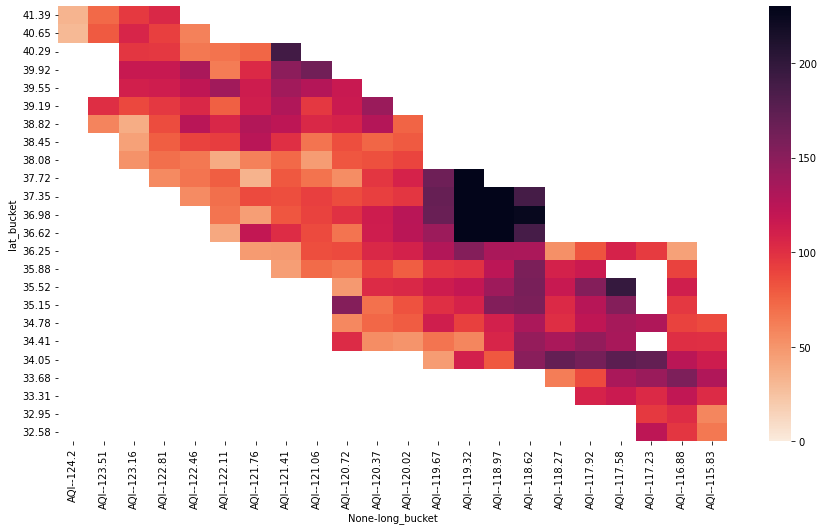

In [37]:
def fill_all(pivot_table):
    new_pt = pivot_table.copy()
    for lat in range(pivot_table.shape[0]):
        for lon in range(pivot_table.shape[1]):
            k = fill_bucket(new_pt, lat, lon)
            new_pt.iloc[lat,lon] = k

    return new_pt


filled_heatmap_data = fill_all(heatmap_data)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(filled_heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [38]:
grader.check("q8b")

q8b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 8c - Other Interpolation Ideas

Instead of just interpolating in a simple fashion as we did above, suggest one other way to interpolate (that actually works so do not just say "put the average of all cells in every `NaN` cell). For example, you can take into account of the distance of the surrounding cells, the number of cells you use, and more. 

<!--
BEGIN QUESTION
name: q8c
points: 2
manual: True
-->

Another way to interpolate would be to incorporate the distance of the nearby cells (above, below, left, and right).  More specifically, we could use an approach that puts lower weight on cells that are farther away compared to cells that are closer. For instance, if the above closest cell is 2 cells away and the right closest cell is 10 cells away; we would fill that bucket with a value much closer to the above cell than the right because it is significantly closer.  To implement this we could simply weight the value of the neighboring cell based upon its proximity to the bucket we are filling.  By exploying a more elegant method of interpolation (in this example using proximity as a heuristic) we gain a more accurate estimate of the bucket we fill.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 9 - Choosing your Loss Function

Let us say that you are trying to define a loss function $L(x_{i}, y_{i})$ to use for model, where $x_{i}$ is the input and the $y_{i}$ is a qualitative variable that that model outputs, consisting of the following five groups: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. How would you design your loss function to evaluate your model?

<!--
BEGIN QUESTION
name: q9
manual: True
points: 2
-->

Sparse categorical cross entropy seems like the best suited loss function for this particular model.  The reason this loss function is our choice is because it is used for multi-class classification models, and in this case we are trying to determine what constitutes good, moderate, unhealthy, etc. The equation of this loss function is $-\sum{i=1}^nt_{i}log(p_{i})$ where $t_{i}$ is the truth or actual label, $p_{i}$ is the probability of the ith class, and n denotes the number of classes in our model (thus n equals 6 for our model).  This loss function penalizes each output probability based upon how far off the probability is from the actual value (truth value).

<!-- END QUESTION -->



</br></br>

### Question 10: Creating your own Model!

Now that you have an idea of how to interpolate values, we will be using something more predictive. In this part, your final goal is to be creating a model and function that uses **at least four** features, with at least one of those four features being from an external dataset that you bring in and process yourself. Here are some rules on the model that you should follow: 

- Using your open-ended EDA analysis, use at least three features in the dataset provided to come up with some sort of predictive model for the AQI for remaining locations not predicted in the heatmap. You are **NOT** allowed to use any more than **one** of the particulate matter features for this model i.e. ozone or CO2 concentrations for example. 
    - The reason behind this is that AQI is directly based on these values, so there will be in some sense a near 100\% correlation between AQI and these features under some transformations. 
- Use at least one feature that comes from an external dataset of choice. Some examples are geographical region (categorical), elevation (quantitative), or wilfire data. 
    - Reference question 2c of this project to see how to merge external data with the current EPA data.
- Your model should, at the end, predict one of the following broad categories for the AQI: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. Note that this specification is different from `fill_bucket` in the sense that instead of returning a value, you will be returning a string for a category.
    - As a result, you can either directly predict the category, or the AQI (ex. through regression) and then convert to the category. Category ranges for AQI can be found online.
- The final model should be validated with some data that you hold out. You decide how to do this but there should be some model validation accuracy reported. You should be using the loss function that you designed in question 3 in order to do this.

---

#### Deliverables
<br/>

**`features`**: This should be a `pd.DataFrame` object that represents the design matrix that will be fed in as input to your model. Each row represents a data point and each column represents a feature. Essentially your $X$ matrix. 

**`targets`**: This should be a numpy array that where each value corresponds to the AQI value or AQI category for each of the data points in `features`. Essentially your $y$ vector. 

**`build_model`**: This function should have two parameters: `features` that will be used as input into your model as a `pd.DataFrame` object, and `targets` should be a numpy array of AQI values OR AQI categories. It should return a *function* or *object* that represents your model.

**`predict`**: This function should have two parameters: `model`, the model that you build from the previous function `build_model`, and `features` that represent the design matrix for the test values that we want to predict. It should return the **AQI category** (not a value) that the model predicts for these inputs.

<!-- BEGIN QUESTION -->

<br/>

### Question 10a: Choose Features and Model

First, decide on the features that you will be using for your model. How predictive do you think each of the features that you chose will be of the AQI category? Then, how will you choose to make your model (multiple regression, decision trees, etc.)?

<!--
BEGIN QUESTION
name: q10a
points: 2
manual: True
-->

_The features that we will be using for our model include: Temperature, Elevation (from AQS Sites dataset), Location Setting (from AQS Sites dataset), and Annual Average Daily Traffic as our external feature from the traffic dataset._

_Temperature should be very predictive of AQI, since according to our part 1 analysis, higher temperatures correlated to higher AQIs. Elevation is more of a wild card requiring some EDA, but we think it might correlate to AQIS in that lower elevations might have higher AQIs. Location Setting (which we will one hot encode) should be predictive of AQIs; urban and suburban locations might be predictive of higher AQIs and rural locations might be predictive of lower AQIs. And finally, the average annual daily traffic might be a proxy for AQI in that traffic density might positively correlate with AQI._

_We are planning on using decision trees to classify the AQI levels of our data as good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. We might even use ensemble methods such as random forests since we are less concerned with interpretability and more concerned with performance on large datasets._

<!-- END QUESTION -->

<br/>

### Question 10b: Build Features

Create the `build_features` function as described at the beginning of this part. You should also do any cleaning or merging of internal or external datasets in this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10b
points: 3
-->

In [48]:
def split_dates(df):
    df['Month'] = pd.to_datetime(df['Date Local']).dt.month  
    df['Day'] = pd.to_datetime(df['Date Local']).dt.day
    return df

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def build_features(q11=False):
    # Features: Temperature (daily_temp), Elevation (AQS Sites), 
    # Location Setting (AQS Sites), AADT (Traffic)
    selected_features = ['State Name', 'county Name', 'County Code', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude', 
                     'Elevation', 'Location Setting']
    data1 = epa_data_CA.get('daily_county_aqi')
    arr = []
    iterate_array = data1['Defining Site']
    for i in iterate_array:
        arr.append(int(i[7:]))
    data1['Site Number'] = arr
    data2 = epa_data.get('aqs_sites')
    data2 = data2[data2['State Name'] == 'California']
    features = data1.merge(data2, on = ['County Code', 'Site Number'])
    features = features.rename(columns = {'State Name_x': 'State Name'})
    features = features[selected_features]
    geom_traffic = gpd.points_from_xy(traffic_data_cleaned.Longitude, traffic_data_cleaned.Latitude)
    geom_merged = gpd.points_from_xy(features.Longitude, features.Latitude)
    gpd_traffic = gpd.GeoDataFrame(traffic_data_cleaned, geometry = geom_traffic)
    gpd_CA_merged = gpd.GeoDataFrame(features, geometry = geom_merged)
    joined = gpd.sjoin_nearest(left_df = gpd_CA_merged, right_df = gpd_traffic, how = "inner") 
    renaming = {"Latitude_left": "Site Lat", "Longitude_left": "Site Long", "Latitude_right": "Traffic Lat", 
                "Longitude_right": "Traffic Long"}
    joined = joined.rename(columns = renaming)
    joined["Traffic Long"] = joined["Traffic Long"].astype(str).astype(float)
    cols = ["State Name", "county Name", 'County Code', "Month", "Day", "AQI", "Category", "Defining Site", "Site Lat", "Site Long", 
            "Traffic Lat", "Traffic Long", "Descriptn", "AADT", 'Elevation', 'Location Setting']
    gpd_epa_traffic = joined[cols]
    arr2 = []
    for i in gpd_epa_traffic['Defining Site']:
        arr2.append(int(i[7:]))
    gpd_epa_traffic['Site Num'] = arr2
    temp = epa_data_CA.get('daily_temp')
    temp = temp[['County Code', 'Site Num', 'Month', 'Day', 'Arithmetic Mean']]
    
    inter = gpd_epa_traffic.merge(temp, on = ["County Code", "Site Num", "Month", "Day"])
    inter = inter[['county Name', 'County Code', 'Site Num', 'Month', 'Day', 'AADT', 'Elevation', 'Location Setting', 'Arithmetic Mean', 'AQI']]
    inter = inter.rename(columns = {'Arithmetic Mean':'Temperature', 'AQI_x':'AQI'})
    
    wind = epa_data_CA.get('daily_wind')
    wind = wind[['County Code', 'Site Num', 'Month', 'Day', 'Arithmetic Mean']]
    
    inter2 = inter.merge(wind, on = ["County Code", "Site Num", "Month", "Day"])
    # inter2 = inter2[['County Code', 'Site Num', 'Month', 'Day', 'AADT', 'Elevation', 'Location Setting', 'Arithmetic Mean', 'AQI', 'Temperature']]
    inter2 = inter2.rename(columns = {'Arithmetic Mean':'Wind'})#, 'AQI_x':'AQI'})

    no2 = epa_data_CA.get('daily_no2')
    no2 = split_dates(no2)
    no2 = no2[['County Code', 'Site Num', 'Month', 'Day', 'Arithmetic Mean']]
    
    final = inter2.merge(no2, on = ["County Code", "Site Num", "Month", "Day"])
    #final = final[['County Code', 'Site Num', 'Month', 'Day', 'AADT', 'Elevation', 'Location Setting', 'Arithmetic Mean', 'AQI']]
    final = final.rename(columns = {'Arithmetic Mean':'NO2'})#, 'AQI_x':'AQI'})
    #final['Carbon Monoxide'] = np.log(final['Carbon Monoxide'])
    
    final = pd.concat([final[['county Name', 'County Code', 'Site Num', 'Month', 'Day', 'AADT', 'Elevation', 'Wind', 'NO2', 'Temperature', 'AQI']], 
                                      pd.get_dummies(final[['Location Setting']], prefix='setting')], axis=1)
    grouped_multiple = final.groupby(['County Code', 'Site Num', 'Month']).agg({ 
                                                                                'Day': 'mean', 
                                                                                'AADT': 'mean', 
                                                                                'Elevation': 'mean', 
                                                                                'Wind': 'mean', 
                                                                                'NO2': 'mean', 
                                                                                'Temperature': 'mean', 
                                                                                'AQI': 'mean', 
                                                                                'setting_RURAL': 'mean', 
                                                                                'setting_SUBURBAN': 'mean',
                                                                                'setting_URBAN AND CENTER CITY': 'mean',
                                                                                'county Name': 'first'})
                                                                  
    grouped_multiple['County Code'] = grouped_multiple.index.get_level_values(0)
    grouped_multiple['Site Num'] = grouped_multiple.index.get_level_values(1)
    grouped_multiple['Month'] = grouped_multiple.index.get_level_values(2)
    grouped_multiple.index = [i for i in range(len(grouped_multiple))]
    grouped_multiple = grouped_multiple[[c for c in grouped_multiple if c not in ['Day', 'AQI']] 
       + ['AQI']]
    grouped_multiple['AADT'] = np.log(grouped_multiple['AADT'])
    grouped_multiple = grouped_multiple.rename(columns={'AADT' : 'Log AADT'})
    # grouped_multiple = grouped_multiple.drop(['County Code', 'Site Num'], axis=1)
    # grouped_multiple = grouped_multiple.drop(['Site Num'], axis=1)
    # grouped_multiple = grouped_multiple.drop('County Code', axis=1)
    # grouped_multiple = grouped_multiple.drop(['setting_RURAL', 'setting_SUBURBAN', 'setting_URBAN AND CENTER CITY'], axis=1)
    if q11 == True:
        grouped_multiple = grouped_multiple.drop(['Site Num', 'setting_RURAL', 'setting_SUBURBAN'], axis=1)
    else:
        grouped_multiple = grouped_multiple.drop(['Site Num', 'County Code', 'setting_RURAL', 'setting_SUBURBAN'], axis=1)
    # , 'setting_URBAN AND CENTER CITY'
    
    # aqi_col = grouped_multiple['AQI']
    # grouped_multiple = grouped_multiple.drop('AQI', axis=1)
    # normalized = normalize(grouped_multiple)
    # normalized['AQI'] = aqi_col
    if q11 == True:
        grouped_multiple = grouped_multiple[['Log AADT', 'county Name', 'Temperature', 'NO2', 'setting_URBAN AND CENTER CITY', 'Elevation', 'AQI']]
    else:
        grouped_multiple = grouped_multiple[['Log AADT', 'Temperature', 'Month', 'NO2', 'setting_URBAN AND CENTER CITY', 'Elevation', 'AQI']]
    
    return grouped_multiple
    #return normalized
    
    

features = build_features().iloc[:, :-1]
targets = build_features().iloc[:, -1]

build_features()




,Log AADT,Temperature,Month,NO2,setting_URBAN AND CENTER CITY,Elevation,AQI
0,11.634258,87.472917,1,10.334783,0.0,1.0,62.875000
1,11.634258,154.500000,2,2.769565,0.0,1.0,58.000000
2,11.634258,71.727084,4,2.400000,0.0,1.0,36.500000
3,11.634258,76.529167,5,3.756522,0.0,1.0,35.000000
4,11.634258,112.606250,6,1.208696,0.0,1.0,67.000000
...,...,...,...,...,...,...,...
445,11.332602,82.527083,8,3.621739,0.0,0.0,92.500000
446,11.332602,119.472916,9,6.020833,0.0,0.0,100.703704
447,11.332602,100.439583,10,3.221739,0.0,0.0,74.071429
448,11.332602,140.393750,11,4.800000,0.0,0.0,49.695652


In [49]:
grader.check("q10b")

q10b results: All test cases passed!

<br/>

### Question 10c: Build Your Model!

Create the `build_model` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10c
points: 8
-->

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

def build_model(features, targets):
    # model = lm.LinearRegression(fit_intercept = True)
    model = RandomForestRegressor(max_depth=20, random_state=0)
    model.fit(features, targets)
    return model

model = build_model(features, targets)

In [51]:
grader.check("q10c")

q10c results: All test cases passed!

<br/>

### Question 10d: Predict Points

Create the `predict` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10d
points: 4
-->

In [52]:
categories = ["good", "moderate", "unhealthy sensitive groups", "unhealthy", "very unhealthy", "hazardous"]

def predict(model, features):
    predictions = model.predict(features)
    classified = []
    for pred in predictions:
        if pred >= 301 and pred <= 500:
            classified = np.append(classified, "hazardous")
        elif pred >= 201:
            classified = np.append(classified, "very unhealthy")
        elif pred >= 151:
            classified = np.append(classified, "unhealthy")
        elif pred >= 101:
            classified = np.append(classified, "unhealthy sensitive groups")
        elif pred >= 51:
            classified = np.append(classified, "moderate")
        else:
            classified = np.append(classified, "good")
    return classified

In [53]:
pd.Series(predict(model, features)).value_counts()

moderate                      236
good                          124
unhealthy sensitive groups     74
unhealthy                      16
dtype: int64

In [54]:
grader.check("q10d")

q10d results: All test cases passed!

<br/>

### Question 10e: Model Validation and Performance

Now that you have finished making your model, we want to see how well it performs on our data. In this question, use the following cell to split your data into training and validation sets. You should partition 70\% of your data to be used as your training set, and the remaining to be used as your validation set. 

Assign `binary_error` to be the **fraction of inputs on your validation set that the your `predict` function classifies incorrectly.** Note that this is a binary loss in some sense as it assigns a loss of 1 to those points predicted incorrectly, and a loss of 0 to those points predicted correctly.

Assign `cv_error` to be the the error on the validation set produced by the loss function $ L $ that you designed in question 3.

*Hint*: you can use `train_test_split` from `sklearn`.

<!--
BEGIN QUESTION
name: q10e
points: 8
-->

In [55]:
import sklearn as sk
from sklearn.model_selection import KFold

X_train, X_validation, y_train, y_validation = sk.model_selection.train_test_split(features, targets, test_size = 0.3, random_state = 42)

def ordinal_rep(arr):
    new = []
    for i in range(len(arr)):
        if arr[i] == "hazardous":
            new = np.append(new, 6)
        elif arr[i] == "very unhealthy":
            new = np.append(new, 5)
        elif arr[i] == "unhealthy":
            new = np.append(new, 4)
        elif arr[i] == "unhealthy sensitive groups":
            new = np.append(new, 3)
        elif arr[i] == "moderate":
            new = np.append(new, 2)
        else:
            new = np.append(new, 1)
    return new
    
def classifier(targets):
    classified = []
    for aqi in targets:
        if aqi >= 301 and aqi <= 500:
            classified = np.append(classified, "hazardous")
        elif aqi >= 201:
            classified = np.append(classified, "very unhealthy")
        elif aqi >= 151:
            classified = np.append(classified, "unhealthy")
        elif aqi >= 101:
            classified = np.append(classified, "unhealthy sensitive groups")
        elif aqi >= 51:
            classified = np.append(classified, "moderate")
        else:
            classified = np.append(classified, "good")
    targets = classified
    targets = pd.DataFrame(targets)
    return targets
    
def get_binary_error(y_hat, y_actual):
    compared = y_hat != y_actual
    return sum(compared) / len(compared)

def categorical_crossentropy(y_pred, y_true):
    # - SUM(target * log(pred))
    return -np.sum(y_true * np.log(y_pred))

def loss_function(y_pred, y_true):
    y_predicted = []
    for aqi in y_pred:
        if aqi >= 301 and aqi <= 500:
            y_predicted = np.append(y_pred, 6)
        elif aqi >= 201:
            y_predicted = np.append(y_pred, 5)
        elif aqi >= 151:
            y_predicted = np.append(y_pred, 4)
        elif aqi >= 101:
            y_predicted = np.append(y_pred, 3)
        elif aqi >= 51:
            y_predicted = np.append(y_pred, 2)
        else:
            y_predicted = np.append(y_pred, 1)
    cverror = np.sum(np.square(y_predicted - y_true)) / len(y_true)
    return cverror

def compute_CV_error(model, X_train, Y_train):
    '''
    Split the training data into 5 subsets.
    For each subset, 
        fit a model holding out that subset
        compute the MSE on that subset (the validation set)
    You should be fitting 5 models total.
    Return the average MSE of these 5 folds.

    Args:
        model: an sklearn model with fit and predict functions 
        X_train (data_frame): Training data
        Y_train (data_frame): Label 

    Return:
        the average validation MSE for the 5 splits.
    '''
    kf = KFold(n_splits=5, shuffle=False)
    validation_errors = []
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        
        split_Y_train_unclassified = split_Y_train
        split_Y_valid_unclassified = split_Y_valid
        
        split_Y_train = classifier(split_Y_train)
        split_Y_valid = classifier(split_Y_valid)

        tempArr = []
        for i in split_Y_train.values:
            tempArr.append(i[0])
        
        
        tempArrChanged = ordinal_rep(tempArr)
        
        # Fit the model on the training split
        unvalidated_lm = model.fit(split_X_train, split_Y_train_unclassified) #creates the model fitted onto the training set
        Y_hat_validation = predict(unvalidated_lm, split_X_valid) #test the model against the validation set
        
        numerical_y_hat = ordinal_rep(Y_hat_validation)
        
        tempArr1 = []
        for i in split_Y_valid.values:
            tempArr1 = np.append(tempArr1, i[0])
        
        tempArrChanged1 = ordinal_rep(tempArr1)
        numerical_y_hat = [int(x) for x in numerical_y_hat]
        error = categorical_crossentropy(numerical_y_hat, tempArrChanged1)
        validation_errors.append(error)
        
    return np.mean(validation_errors)
    
cv_error = np.abs(compute_CV_error(model, X_validation, y_validation))
y_validation = classifier(y_validation)[0]
binary_error = sum((predict(model, X_validation) != y_validation)) / len(X_validation)

print(binary_error)
print(cv_error)

0.2222222222222222
40.072455282866734


In [56]:
grader.check("q10e")

q10e results: All test cases passed!

<br/><br/>

---
## Part 5: Open-Ended Modeling

Now that you have had some experience with creating the a model from scratch using the existing data, you are now ready to explore other questions, such as the ones in your design document. In this section, you will use the tools that we developed in the previous parts to answer the hypothesis of your choice! Note that breaking your model-building and analysis process into modularized functions as you did above will make your code more interpretable and less error-prone. 

<!-- BEGIN QUESTION -->

### Question 11a

Train a baseline model of your choice using any supervised learning approach we have studied to answer your hypothesis and predict something related to AQI; you are not limited to a linear model. However, you may use a maximum of **three features** for this part. After training, evaluate it on some validation data that you hold out yourself. 

<!--
BEGIN QUESTION
name: q11a
points: 5
manual: True
-->

In [57]:
wildfire_data1 = pd.read_csv("data/WFIGS_-_Wildland_Fire_Locations_Full_History.csv")
annual_county_aqi1 = pd.read_csv("data/annual_county_aqi/annual_aqi_by_county_2020.csv")

The RandomForestClassifier model's performance on testing set
--------------------------------------
Confusion Matrix

[[0 0 0 2 1]
 [0 0 0 0 2]
 [0 0 0 1 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]

Accuracy: 0.00


Classification Report

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       3.0
           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       1.0

    accuracy                           0.00       7.0
   macro avg       0.00      0.00      0.00       7.0
weighted avg       0.00      0.00      0.00       7.0


5-Fold Cross Validation Error: [0.  0.  0.5]

5-Fold Cross Validation Error: [-1331.53412612    -3.77769144   -39.48661909]
The LinearRegression model's performance on testing set
--------------------------------------
MAE is 21.9455642184708
MSE is 982.0119358249698
R2 score is -4.1

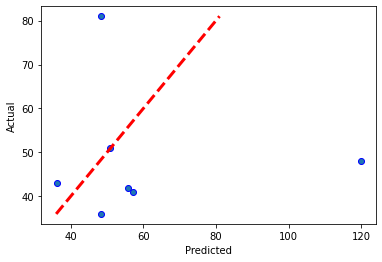


5-Fold Cross Validation Error: [-1.08057674 -8.66445313 -0.75132385]
The RandomForestRegressor model's performance on testing set
--------------------------------------
MAE is 10.194285714285714
MSE is 131.78954285714286
R2 score is -1.2500653658536587


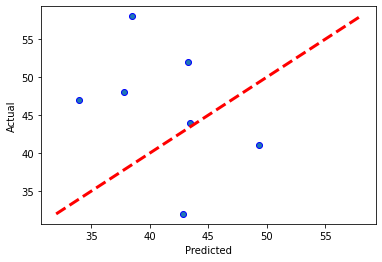

In [64]:
import datetime as dt
import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_validate, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


wildfire_data = wildfire_data1
annual_county_aqi = annual_county_aqi1

columns = ["POOCounty", "DailyAcres", 'FireBehaviorGeneral', "FireDiscoveryDateTime", "FireOutDateTime", "POOState"]
def wildfire_setup(wildfire_data, cols):
    wildfire_data = wildfire_data[cols]
    wildfire_data = wildfire_data[wildfire_data['POOState'] == 'US-CA'].drop('POOState', axis=1)
    wildfire_data = wildfire_data[wildfire_data['DailyAcres'].notnull()]
    # wildfire_data['Year'] = pd.to_datetime(wildfire_data['FireDiscoveryDateTime'], errors='coerce').dt.year
    # wildfire_data = wildfire_data[wildfire_data['Year'] == 2020]
    # Get one hot encoding of FireBehaviorGeneral column
    one_hot = pd.get_dummies(wildfire_data['FireBehaviorGeneral'], prefix='behavior')
    # Drop column  as it is now encoded
    wildfire_data = wildfire_data.drop('FireBehaviorGeneral', axis = 1)
    # Join the encoded df
    wildfire_data = wildfire_data.join(one_hot)
    return wildfire_data

def create_datetime_difference(df, date1, date2, duration_title):
    df = df[df[date1].notnull()][df[date2].notnull()]
    col1 = pd.to_datetime(df[date1], errors = 'coerce')
    col2 = pd.to_datetime(df[date2], errors = 'coerce')
    duration = (col2 - col1).dt.days
    df[duration_title] = duration
    df = df[df[duration_title].notnull()]
    df = df[df[duration_title] >= 0]
    df = df.drop([date1, date2], axis=1)
    return df
    
def group_by_county(df, minimum_threshold):
    v = df.POOCounty.value_counts()
    df = df[df.POOCounty.isin(v.index[v.gt(minimum_threshold)])]
    df = df.drop(['behavior_Moderate'], axis=1)
    df = df.groupby('POOCounty').agg(
            median_dailyacres=('DailyAcres', np.median),
            count_ActiveBehavior=('behavior_Active', np.sum),
            count_ExtremeBehavior=('behavior_Extreme', np.sum),
            mean_FireDurationDays=('FireDurationDays', np.mean)
        )
    df['count_ExtremeOrActiveBehavior'] = df['count_ActiveBehavior'] + df['count_ExtremeBehavior']
    df = df.drop(['count_ActiveBehavior', 'count_ExtremeBehavior'], axis=1)
    df = df.reset_index()
    return df

def merge_with_annualcountyaqi(df, annual_county_aqi):
    annual_county_aqi = annual_county_aqi[annual_county_aqi['State'] == 'California']
    annual_county_aqi = annual_county_aqi[['County', 'Median AQI']]
    df = df.rename(columns = {'POOCounty': 'County'})
    df = df.merge(annual_county_aqi, on=['County'])
    return df

def create_initial_model(df, rf=False, rfr=False, lr=False, binned=False):
    if binned == True:
        df = df.copy()
        df['Median AQI Bins'] = pd.qcut(x=df['Median AQI'],
                                        q=5,
                                        labels=False)
        df = df.drop('Median AQI', axis=1)
    df = df.drop('County', axis=1)
    features = df.iloc[:, :-1]
    targets = df.iloc[:, -1]
    X_train, X_rem, y_train, y_rem = train_test_split(features, targets, train_size=0.6)
    X_validation, X_test, y_validation, y_test = train_test_split(X_rem, y_rem, train_size=0.5)
    if rf == True:
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, X_val=X_validation, y_val=y_validation, is_classifier=True, initial_nsplits=3)
        return model
        
    if rfr == True:
        model = RandomForestRegressor(n_estimators=100, random_state=0)
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, X_val=X_validation, y_val=y_validation, initial_nsplits=3)
        return model
    if lr == True:
        model = LinearRegression(normalize=True)
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, X_val=X_validation, y_val=y_validation, initial_nsplits=3)
        return model
    
def cross_validation(model, X, y, n_splits=5, is_classifier=False, initial_nsplits=None):
    if initial_nsplits != None:
        n_splits = initial_nsplits
    scores = cross_val_score(model, X, y, cv=n_splits)
    return scores

def merge_with_q10data(wildfire_data):
    wildfire_data = wildfire_data.iloc[:, :-1].rename(columns={'County':'county Name'})
    df = build_features(q11=True)
    df = df.merge(wildfire_data, on='county Name')
    df = df[[c for c in df if c not in ['AQI']] 
       + ['AQI']]
    return df

def create_second_model(df, rf=False, rfr=False, lr=False, binned=False):
    df = merge_with_q10data(df).drop(['county Name'], axis=1)
    if binned == True:
        df = df.copy()
        df['AQI Bins'] = pd.qcut(x=df['AQI'],
                                        q=5,
                                        labels=False)
        df = df.drop('AQI', axis=1)
    features = df.iloc[:, :-1]
    targets = df.iloc[:, -1]
    X_train, X_rem, y_train, y_rem = train_test_split(features, targets, train_size=0.65)
    X_validation, X_test, y_validation, y_test = train_test_split(X_rem, y_rem, train_size=0.5)
    if rf == True:
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, X_val=X_validation, y_val=y_validation, is_classifier=True)
    if rfr == True:
        model = RandomForestRegressor(n_estimators=100, random_state=0)
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, X_val=X_validation, y_val=y_validation)
        return model
    if lr == True:
        model = LinearRegression()
        model.fit(X_train, y_train)
        evaluate_model(model, X_test, y_test, X_val=X_validation, y_val=y_validation)
        return model
    
def evaluate_model(model, X_test, y_test, X_val=None, y_val=None, is_classifier=False, initial_nsplits=None):
    y_predicted = model.predict(X_test)
    if is_classifier==True:
        print("The {0} model's performance on testing set".format(type(model).__name__))
        print("--------------------------------------")
        confusion = confusion_matrix(y_test, y_predicted)
        print('Confusion Matrix\n')
        print(confusion)

        #importing accuracy_score, precision_score, recall_score, f1_score
        print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_predicted)))
        print('\nClassification Report\n')
        print(classification_report(y_test, y_predicted))
        print('\n5-Fold Cross Validation Error: {0}'.format(cross_validation(model, X_val, y_val, initial_nsplits)))
    else:
        # model evaluation for testing set
        mae = skl.metrics.mean_absolute_error(y_test, y_predicted)
        mse = skl.metrics.mean_squared_error(y_test, y_predicted)
        r2 = skl.metrics.r2_score(y_test, y_predicted)
        print('\n5-Fold Cross Validation Error: {0}'.format(cross_validation(model, X_val, y_val, initial_nsplits)))
        print("The {0} model's performance on testing set".format(type(model).__name__))
        print("--------------------------------------")
        print('MAE is {}'.format(mae))
        print('MSE is {}'.format(mse))
        print('R2 score is {}'.format(r2))
        fig, ax = plt.subplots()
        ax.scatter(y_predicted, y_test, edgecolors=(0, 0, 1))
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        plt.show()
    
    
    
wildfire_data = wildfire_setup(wildfire_data, columns)
wildfire_data = create_datetime_difference(wildfire_data, 'FireDiscoveryDateTime', 'FireOutDateTime', 'FireDurationDays')
wildfire_data = group_by_county(wildfire_data, 10)
wildfire_data = merge_with_annualcountyaqi(wildfire_data, annual_county_aqi)

initial_rf_model = create_initial_model(wildfire_data, rf=True, binned=True)
initial_lr_model = create_initial_model(wildfire_data,lr=True)
initial_rfr_model = create_initial_model(wildfire_data, rfr=True)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11b

Explain and summarize the model that you used. In your summary, make sure to include the model description, the inputs, the outputs, as well as the cross-validation error. Additionally, talk a little bit about what you would change to your baseline model to improve it. The expected length of your summary should be 8-12 sentences. 

<!--
BEGIN QUESTION
name: q11b
points: 2
manual: True
-->

The models I used are random forests, linear regression, and random forest regressor. I used these three models as baseline models to work with my sparse county-wise wildfire data to check whether there are any generalizable trends between counties' wildfire histories and annual median AQIs. Since the data was sprase, validation errors were mostly meaningless. Changes to my baseline models are addressed in question 11c and the modeling report.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11c

Improve your model from part 11a based on the improvements that you suggested in part 11b. This could be the addition of more features, performing additional transformations on your features, increasing/decreasing the complexity of the model itself, or really anything else. You have no limitation on the number of features you can use, but you are required to use at least **one external dataset** that you process and merge in yourself. 

<!--
BEGIN QUESTION
name: q11c
points: 8
manual: True
-->

The RandomForestClassifier model's performance on testing set
--------------------------------------
Confusion Matrix

[[8 3 1 1 1]
 [2 2 1 3 1]
 [1 2 5 4 0]
 [1 2 1 4 0]
 [1 2 3 2 6]]

Accuracy: 0.44


Classification Report

              precision    recall  f1-score   support

           0       0.62      0.57      0.59        14
           1       0.18      0.22      0.20         9
           2       0.45      0.42      0.43        12
           3       0.29      0.50      0.36         8
           4       0.75      0.43      0.55        14

    accuracy                           0.44        57
   macro avg       0.46      0.43      0.43        57
weighted avg       0.50      0.44      0.45        57


5-Fold Cross Validation Error: [0.5        0.25       0.45454545 0.27272727 0.18181818]

5-Fold Cross Validation Error: [ 0.06554327 -1.06567495 -0.01041527  0.12462402 -5.01046467]
The LinearRegression model's performance on testing set
--------------------------------------
MAE is 

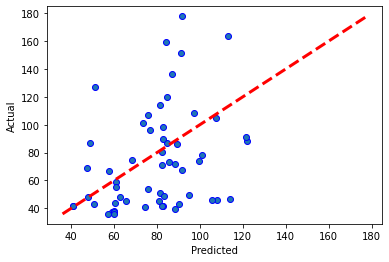


5-Fold Cross Validation Error: [-0.12192728  0.22538143  0.29405601 -0.30422749 -0.02796827]
The RandomForestRegressor model's performance on testing set
--------------------------------------
MAE is 29.648537082697697
MSE is 1334.4198739316714
R2 score is 0.17773934161361027


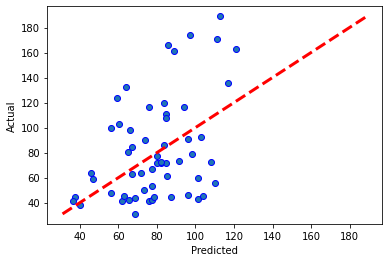

In [68]:
second_rf_model = create_second_model(wildfire_data, rf=True, binned=True)
second_lr_model = create_second_model(wildfire_data, lr=True)
second_rfr_model = create_second_model(wildfire_data, rfr=True)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11d

Compare and contrast your baseline model and (hopefully) improved model. Make sure to compare their validation errors. Were you able to successfully answer your research question and evaluate your hypothesis? Summarize in a few sentences the conclusions that you can draw from your model and predictions. The expected length of your response should be 8-10 sentences. 

<!--
BEGIN QUESTION
name: q11d
points: 3
manual: True
-->

Our baseline model(s) [random forest, linear regression, random forest regressor] was clearly deficient since the data was so sparse. The reason we modelled with the baseline data is to see if we can glean any hidden generalizable trends between the wildfire data of various different counties. Since the data was obviously sparse in terms of datapoints, the validation error is high and volatile. Our target variable for the baseline model was the annual median AQI for Californian counties in the year of 2020. Because we quickly saw via modelling that we couldn't generalize wildfire --> AQI predictivity between counties, we moved on to using counties' wildfire data features as reinforcements to our question 10 feature engineering to predict monthly average AQI for all sites in all Californian counties.

Our improved model as can be observed in 11c is superior in terms of predictivity, as we can clearly see that we have gotten roughly the correct trend in our regression models. Thus, our validation errors are lower. Overall, with the limited features we worked with from wildfire data, amending it to our EPA features led us in the right direction in terms of prediction. Our research question was partially answered since wildfire data seems to be somewhat predictive of AQI.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [69]:
grader.check_all()

q10b results: All test cases passed!

q10c results: All test cases passed!

q10d results: All test cases passed!

q10e results: All test cases passed!

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results:
    q1c - 1 result:
        Trying:
            set(epa_data_CA_merged.columns) == set(['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category',
                   'Defining Site', 'Latitude', 'Longitude'])
        Expecting:
            True
        **********************************************************************
        Line 1, in q1c 0
        Failed example:
            set(epa_data_CA_merged.columns) == set(['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category',
                   'Defining Site', 'Latitude', 'Longitude'])
        Expected:
            True
        Got:
            False

    q1c - 2 result:
        Trying:
            assert epa_data_CA_merged[epa_data_CA_merged['county Name'] == 'Alameda'].shape == (366, 9

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()